# EduVerse USA Chatbot — Context Management

## NLP Pipeline Module 4

This notebook demonstrates dialogue state tracking for multi-turn conversations.

### Features
- Maintain state across conversation turns
- Accumulate entities without losing prior information
- Track intent transitions
- Generate context strings for response grounding

---
## 1. Setup

In [3]:
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Any
from datetime import datetime
import json
import matplotlib.pyplot as plt

print("Setup complete")

Setup complete


---
## 2. Dialogue State Structure

In [5]:
@dataclass
class DialogueState:
    """Maintains conversation state."""
    current_intent: Optional[str] = None
    intent_history: List[str] = field(default_factory=list)
    universities: List[str] = field(default_factory=list)
    programs: List[str] = field(default_factory=list)
    locations: List[str] = field(default_factory=list)
    tests: List[str] = field(default_factory=list)
    deadlines: List[str] = field(default_factory=list)
    scores: Dict[str, str] = field(default_factory=dict)
    turn_count: int = 0
    
    def to_dict(self) -> Dict:
        return {
            'current_intent': self.current_intent,
            'intent_history': self.intent_history,
            'universities': self.universities,
            'programs': self.programs,
            'tests': self.tests,
            'scores': self.scores,
            'turn_count': self.turn_count
        }

state = DialogueState()
print("Initial state:")
print(json.dumps(state.to_dict(), indent=2))

Initial state:
{
  "current_intent": null,
  "intent_history": [],
  "universities": [],
  "programs": [],
  "tests": [],
  "scores": {},
  "turn_count": 0
}


---
## 3. State Update Functions

In [7]:
def update_state(state: DialogueState, intent: Optional[str], entities: Dict) -> DialogueState:
    """Update state with new turn information."""
    state.turn_count += 1
    
    if intent:
        state.current_intent = intent
        state.intent_history.append(intent)
    
    # Merge entities (deduplicate)
    for key in ['universities', 'programs', 'locations', 'tests', 'deadlines']:
        if key in entities and entities[key]:
            current = getattr(state, key)
            merged = list(dict.fromkeys(current + entities[key]))
            setattr(state, key, merged)
    
    if 'scores' in entities:
        state.scores.update(entities['scores'])
    
    return state


def get_context_string(state: DialogueState) -> str:
    """Generate context summary."""
    parts = []
    if state.current_intent:
        parts.append(f"Intent: {state.current_intent}")
    if state.universities:
        parts.append(f"Universities: {', '.join(state.universities)}")
    if state.programs:
        parts.append(f"Programs: {', '.join(state.programs[:2])}")
    if state.tests:
        parts.append(f"Tests: {', '.join(state.tests)}")
    if state.scores:
        score_str = ', '.join([f"{k.upper()}: {v}" for k, v in state.scores.items()])
        parts.append(f"Scores: {score_str}")
    return ' | '.join(parts) if parts else '(No context)'

---
## 4. Multi-Turn Conversation Simulation

In [9]:
conversation = [
    {
        'user': "I want to apply for MS in Computer Science at Stanford.",
        'intent': 'admissions',
        'entities': {
            'universities': ['Stanford'],
            'programs': ['MS in Computer Science']
        }
    },
    {
        'user': "My GPA is 3.8 and I'm targeting Fall 2026.",
        'intent': 'admissions',
        'entities': {
            'scores': {'gpa': '3.8'},
            'deadlines': ['Fall 2026']
        }
    },
    {
        'user': "What GRE score do I need?",
        'intent': 'test_prep',
        'entities': {'tests': ['GRE']}
    },
    {
        'user': "Also looking at MIT as backup.",
        'intent': 'admissions',
        'entities': {'universities': ['MIT']}
    },
    {
        'user': "Any scholarships available?",
        'intent': 'scholarships',
        'entities': {}
    }
]

state = DialogueState()
print("Conversation Simulation")
print("=" * 60)

for turn in conversation:
    state = update_state(state, turn['intent'], turn['entities'])
    print(f"\nTurn {state.turn_count}: {turn['user']}")
    print(f"→ Context: {get_context_string(state)}")

Conversation Simulation

Turn 1: I want to apply for MS in Computer Science at Stanford.
→ Context: Intent: admissions | Universities: Stanford | Programs: MS in Computer Science

Turn 2: My GPA is 3.8 and I'm targeting Fall 2026.
→ Context: Intent: admissions | Universities: Stanford | Programs: MS in Computer Science | Scores: GPA: 3.8

Turn 3: What GRE score do I need?
→ Context: Intent: test_prep | Universities: Stanford | Programs: MS in Computer Science | Tests: GRE | Scores: GPA: 3.8

Turn 4: Also looking at MIT as backup.
→ Context: Intent: admissions | Universities: Stanford, MIT | Programs: MS in Computer Science | Tests: GRE | Scores: GPA: 3.8

Turn 5: Any scholarships available?
→ Context: Intent: scholarships | Universities: Stanford, MIT | Programs: MS in Computer Science | Tests: GRE | Scores: GPA: 3.8


---
## 5. Entity Accumulation Visualization

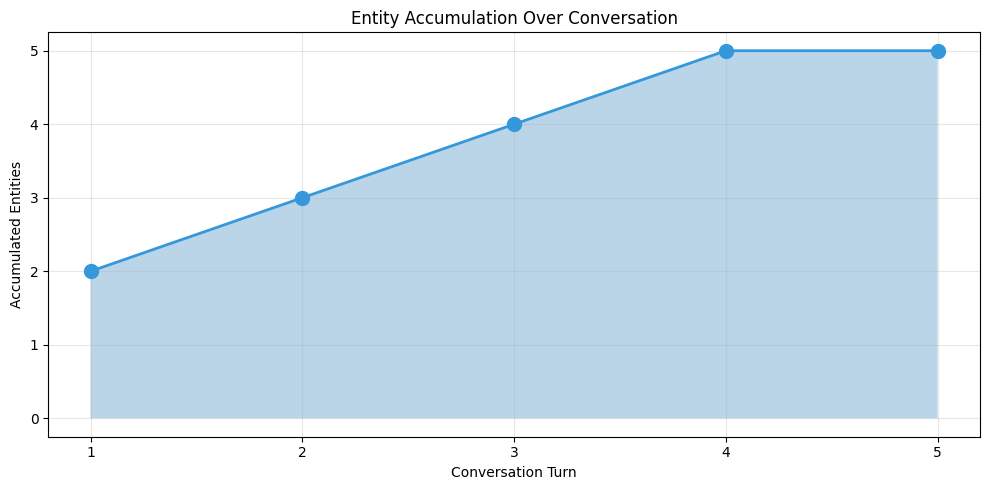

In [11]:
# Track state evolution
state = DialogueState()
history = []

for turn in conversation:
    state = update_state(state, turn['intent'], turn['entities'])
    history.append({
        'turn': state.turn_count,
        'intent': state.current_intent,
        'entity_count': (
            len(state.universities) + 
            len(state.programs) + 
            len(state.tests) + 
            len(state.scores)
        )
    })

turns = [h['turn'] for h in history]
entities = [h['entity_count'] for h in history]

plt.figure(figsize=(10, 5))
plt.plot(turns, entities, marker='o', linewidth=2, markersize=10, color='#3498db')
plt.fill_between(turns, entities, alpha=0.3)
plt.xlabel('Conversation Turn')
plt.ylabel('Accumulated Entities')
plt.title('Entity Accumulation Over Conversation')
plt.xticks(turns)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 6. Intent Flow Visualization

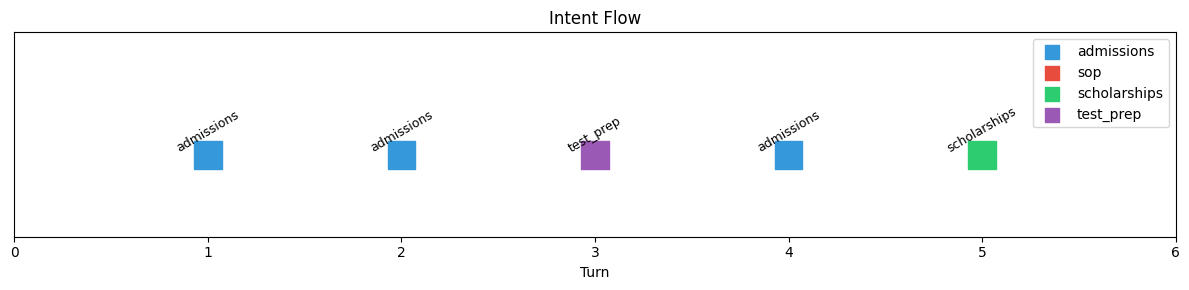

In [13]:
intent_colors = {
    'admissions': '#3498db',
    'sop': '#e74c3c',
    'scholarships': '#2ecc71',
    'test_prep': '#9b59b6'
}

intents = [h['intent'] for h in history]
colors = [intent_colors.get(i, '#95a5a6') for i in intents]

plt.figure(figsize=(12, 3))
plt.scatter(turns, [1]*len(turns), c=colors, s=400, marker='s')

for i, intent in enumerate(intents):
    plt.annotate(intent, (turns[i], 1), ha='center', va='bottom', fontsize=9, rotation=30)

plt.xlim(0, max(turns) + 1)
plt.ylim(0.8, 1.3)
plt.xlabel('Turn')
plt.title('Intent Flow')
plt.yticks([])

for intent, color in intent_colors.items():
    plt.scatter([], [], c=color, s=100, label=intent, marker='s')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

---
## 7. Context-Aware Response

In [15]:
def generate_contextual_response(state: DialogueState) -> str:
    """Generate response based on state."""
    parts = []
    
    if state.universities:
        parts.append(f"Based on your interest in {', '.join(state.universities)}")
    if state.programs:
        parts.append(f"for {state.programs[0]}")
    
    if state.current_intent == 'scholarships':
        parts.append(", here are funding options: merit scholarships, TA/RA, fellowships.")
    elif state.current_intent == 'test_prep' and state.scores.get('gpa'):
        parts.append(f", with your GPA of {state.scores['gpa']}, aim for GRE 320+.")
    
    return ' '.join(parts) if parts else "How can I help?"

print("Contextual Response:")
print(generate_contextual_response(state))

Contextual Response:
Based on your interest in Stanford, MIT for MS in Computer Science , here are funding options: merit scholarships, TA/RA, fellowships.


---
## 8. Final State

In [17]:
print("Final State After 5 Turns:")
print(json.dumps(state.to_dict(), indent=2))

Final State After 5 Turns:
{
  "current_intent": "scholarships",
  "intent_history": [
    "admissions",
    "admissions",
    "test_prep",
    "admissions",
    "scholarships"
  ],
  "universities": [
    "Stanford",
    "MIT"
  ],
  "programs": [
    "MS in Computer Science"
  ],
  "tests": [
    "GRE"
  ],
  "scores": {
    "gpa": "3.8"
  },
  "turn_count": 5
}


---
## 9. Summary

### Context Management Features
- **State tracking** across multiple turns
- **Entity accumulation** with deduplication
- **Intent history** for flow analysis
- **Context strings** for response grounding

### Key Takeaways
1. Stateful conversations improve user experience
2. Entity merging preserves information across turns
3. Visualization aids in debugging conversation flows